# Stability comparison RDMA-XDP

## Method

### Introduction

The purpose of this experiment is to evaluate the latency and jitter in communication using kernel bypass methods XDP and RDMA.
Also, this experiment tries to evaluate what are the causes of jitter and where are most present (rx, tx, or both).

**Null hypothesis $H_0$**: There is no relevant difference in latency and jitter between XDP and RDMA bypass.

### Variables

| Independent variable | Levels |
| --- | --- |
| Technology | XDP Poll, AF_XDP, RDMA RC, RDMA UD |
| Send interval | 5 $\mu s$, 10 $\mu s$, 100 $\mu s$, 1 $ms$ |
| Number of packets | 1 million, 10 million, 1 billion |
| Isolation | No isolation, core isolation, full isolation (?) |

| Dependent variable | Scale | Description |
| --- | --- | --- |
| Application-level timestamps | Nanoseconds? | As later explained in "Design", for each packet, 4 timestamps are taken in the application. |
| NIC-level timestamps | Nanoseconds? | For each packet, 4 timestamps are taken in the NIC at exact rx and tx times. |

| Control variable | Fixed value |
| --- | --- |
| Machine workload | The machines are booted with a clean operating system and have no other program running |
| Network worload | The network contains no other traffic other than the experiment packets |
| Packet size | 1024B |

### Design
The experiment consists in a pingpong with timestamps measured at key parts of the communication in order to be able to compute metrics like latency and jitter.

A pingpong round works as follows:

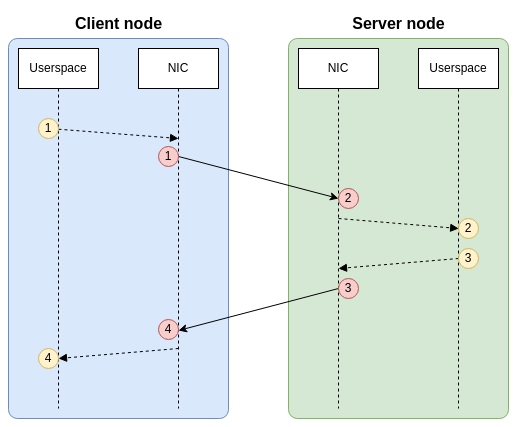

In [6]:
from IPython.display import Image
Image(filename='img/ts_diagram.png')

In the drawing, the path of a single packet is shown over time with arrows; the yellow and red circles represents respectively the timestamps taken at application-level and NIC-level.

The comparison will be held between 4 kernel bypass technologies: XDP Poll, AF_XDP, RDMA RC, RDMA UD.

#### XDP Poll
The XDP Poll bypass mechanism is based on eBPF XDP technology and is composed by the XDP filter and the userspace app.

The XDP filter takes care of intercepting the pingpong packets, which are flagged with a custom Ethernet header. For each packet, assuming it's valid, the filter adds it to a Single-Producer Single-Consumer queue implemented using a eBPF map.

The userspace app will `mmap` the memory area of the eBPF map and it will continuously poll it for new packets. When a packet becomes available, it can be handled by the app.
Synchronization is enforced by a magic number at the end of the packet, which makes sure that XDP has written the entire packet before the app tries to poll it.

#### AF_XDP
[*AF_XDP*](https://www.kernel.org/doc/html/next/networking/af_xdp.html) uses socket with the homonymous address family to allow for kernel bypass and *high performance packet processing*.

The user-space app must create a UMEM region, a shared memory region where packets are written from and to. Each UMEM is associated with two rings, which are used to synchronize ownership of the UMEM slots between kernel space and user space: the **completion ring** transfers ownership of frames from the kernel to the user space and it will contain the frames that were transmitted and user-space can use again; the **fill ring** transfers ownership from user-space to kernel-space and it contains the frames that are available for reception.

Each socket is individually associated with two extra rings: the **rx ring** is populated by the kernel using **fill ring** entries and contains the UMEM frames that contain a newly received packet; the **tx ring** is populated by the user-space app using **completion ring** entries and notifies the kernel of packets that are ready to be transmitted.

In order to use AF_XDP, a XDP filter is required as well. 
The filter contains a map of special type `BPF_MAP_TYPE_XSKMAP`, which contains a list of all the AF_XDP sockets active in user-space. Once XDP receives a packet, it can choose to redirect it to a specific socket using the map.

#### RDMA RC
Both the RDMA kernel bypass mechanisms are implemented with RoCE and using SEND/RECV messages, since the CPU must be notified in order to handle the newly received packet.

The RDMA RC uses a *Reliable Connection* transport type, which consists in a reliable channel that ensures packets order and no packet loss. 
Such a transport uses ACK messages to let the sender know that the packet was received, with a limit of packets that can outstanding with no ACK received. This type of connection closely the TCP transport type.

The communication starts with the creation of the entities that allow the connection. A **Protection Domain** is first created, which groups all the memory that is handled by the NIC. Multiple **Memory Region**s are then created, which represent parts of memory that the RDMA communication can read and write. Our pingpong experiment has a write MR and a send MR, to allow simultaneous bi-directional communication. A **Queue Pair** is then created, composed of a **Send queue** and **Receive queue**: the RQ contains messages of type RECV, which explicit the available to accept a SEND request from the other host; the SQ contains SEND messages, which need to be "submitted" to the other host and hopefully matched with a RECV. Each message is a **Work Queue Entry** and both the SQ and RQ are **Work Queue**s. 
The app also creates a **Completion Queue**: here, a **Completion Queue Entry** will be added every time a WQE is completed. Polling the CQ is used to know whether the send of a packet was successful or whether there is a newly received packet to be handled.

#### RDMA UD
RDMA UD bypass uses RoCE similarly to RDMA RC, but is run on top of the *Unreliable Datagram* transport type, which resembles UDP and ensures no kind of reliability in the communication.

### Apparatus
The experiments are run on remote machines, accessed through SSH.

**Hardware**: Cloudlab [xl170](https://www.utah.cloudlab.us/portal/show-nodetype.php?type=xl170) machines

**OS**: Ubuntu 22.04.2 LTS (GNU/Linux 5.15.0-86-generic x86_64)

**libbpf**: Version 1.3.0

All other packages are installed using *apt* and thus their version corresponds to the latest made available by the OS.

### Procedure

A single run consists of a specific number of rounds, i.e. the number of packets that are sent.

The following measurements are defined:
- Latency (or delay): The time the packet has traveled in the network, i.e. the difference between the reception time and the send time. However, since the timestamping is relative to the machine, and is not globally synchronized, timestamps from different machine cannot be directly compared. For this reason the pingpong is used, since it can measure the RTT and therefore approximate the latency as RTT/2:

  $L = \cfrac{(t_4-t_1)-(t_3-t_2)}{2}$

  where $t_i$ is the $i^{th}$ timestamp as shown in the diagram. Note that these timestamps can either be NIC or userspace, but they must be coherent.

- Jitter: variation of the delay in a sample of packets; the higher the jitter, the more the delays of the packets will differ from each other. If jitter=0, then all packets have exactly the same delay. It can be computed as the average deviation from the mean of the delay:

  $J = \sqrt{\cfrac{\sum_{i=1}^{N} |L_i - \overline{L}|}{N}}$

Fixed the number of packets and send interval, an experimental run consists of:
1. The client and the server exchange their network information using UDP: Ethernet, IP addresses for XDP; LID, QPN, PSN, GID for RDMA.
2. The client machine starts a thread that sends packets every `interval` nanoseconds until all packets are sent.
3. Both the client and server listen for incoming packets until all are received.
4. The experiment ends.

For the data analysis, the first 100 (?) packets are discarded as a "warm-up".

## Analysis

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def parse_timestamps(filename: str, warmup=100) -> np.ndarray:
    """
    Read the content of filename and parse the timestamps it contains.
    The content should follow the format:
    <packet id> <timestamp 1> <timestamp 2> <timestamp 3> <timestamp 4>
    """
    data = np.fromfile(filename, sep=" ", dtype=int)
    arr = np.reshape(data, (len(data)//5,5))
    return arr

In [4]:
def compute_latency(ts) -> int:
    return ((ts[3]-ts[0])-(ts[2]-ts[1]))//2

In [5]:
def compute_latencies(timestamps: np.ndarray) -> np.ndarray:
    """
    Compute the latency of each packet.
    Given the timestamps ts1,ts2,ts3,ts4 of the packet, latency is approximated as:
    L = ((ts4-ts1)-(ts3-ts2))/2
    """
    lat = lambda round: np.array([round[0],compute_latency(round[1:])])
    return np.array([lat(round) for round in timestamps])

In [6]:
def compute_diffs(timestamps: np.ndarray) -> np.ndarray:
    return np.array([np.array([timestamps[i][0],*((timestamps[i]-timestamps[i-1])[1:])]) for i in range(1,len(timestamps))])# if timestamps[i][0] == timestamps[i-1][0]+1])

In [7]:
def compute_jitter(latencies: np.ndarray) -> np.ndarray:
    """
    Compute jitter from latencies of the packets.
    Jitter is computed as the average deviation from the mean of the latencies.
    """
    N = len(latencies)
    avg = np.mean(latencies[:,1])
    s = np.sum(np.abs(latencies[:,1]-avg))
    return np.sqrt(s/N)

In [8]:
def plot_multi_scatter(ax, xvals, *args):
    for arg,name in args:
        y = np.full(xvals, None)
        for val in arg:
            y[val[0]-1] = val[1]
        ax.scatter(x=range(xvals), y=y, s=1, label=name)

In [9]:
def plot_latencies(*args, iters=0):
    fig,ax = plt.subplots(1,1)
    ax.grid(linestyle="--")
    ax.set_xlabel("Packet id")
    ax.set_ylabel("Packet latency (ns)")
    ax.set_title(f"Latency comparison for {', '.join([a[1] for a in args])}")
    plot_multi_scatter(ax, iters, *args)
    ax.legend()

In [10]:
def plot_diffs(diffs: np.ndarray, iters=0):
    fig,axs = plt.subplots(2,2)
    fig.suptitle("Timestamp difference between consequent packets")
    fig.tight_layout()
    fig.set_size_inches(13,6)
    values = np.full([iters,4], None)
    for diff in diffs:
        values[diff[0]-1] = diff[1:]
    for i in range(2*2):
        ax = axs[i//2][i%2]
        ax.grid(linestyle="-")
        ax.set_xlabel("Packet index")
        ax.set_ylabel("Timestamp difference (ns)")
        ax.set_title(f"{'PING' if i<2 else 'PONG'} at {'RECV' if i&1 else 'SEND'}")
        ax.scatter(x=range(iters), y=values[:,i], s=1)

In [11]:
def copy_remote_file (remote_addr: str, local_path: str):
    import os
    if not os.path.isfile(local_path):
        os.system(f"rsync -r {remote_addr} {local_path}")

In [132]:
def to_unit (value: int, base_unit: str, mult: int = 0) -> str:
    """
    Convert value to the correct unit. For example, 1000m should become 1km.

    :param value: the value to transform to string
    :param base_unit: the base unit of the value, e.g. 's' (seconds), 'm' (meters), etc.
    :param mult: optional parameter, represents the value of the current unit in the base unit, expressed as the exponent of 10.
    :return the string with the unit that makes the value the smallest.

    For example, to transform 'ns', the function can be called as:
    > to_unit (10000, 's', -9)
    > "10us"
    Multiplier is 1e-9 because 1ns is 1e-9s.
    """
    from math import floor
    units = {-9: 'n', -6: 'u', -3: 'm', 0: '', 3: 'k', 6: 'M', 9: 'G'}
    l = floor(np.log10(value)) + mult
    idx = 3*(l//3)
    letter = units[idx]
    val = value/(10**(idx-mult))
    if floor(val) == val:
        val = floor(val)
    return f"{val}{letter}{base_unit}"
    
    
class Settings:
    def __init__(self, iters, interval, **kwargs):
        self.iters = iters
        self.interval = interval
        self.kwargs = kwargs

    def __str__(self):
        kwarg_strs = '-'.join(f"{key}_{value}" for key,value in self.kwargs.items())
        parts = [to_unit (self.iters, ''), to_unit (self.interval, 's', -9)]
        if len(self.kwargs) > 0:
            parts.append(kwarg_strs)
        return '-'.join(parts)


In [135]:
settings = Settings(1e6, 1e4, isol="no")

In [14]:
copy_remote_file ("swystems.xdp1:/users/mdr/xdp/build/pingpong.dat", f"./data/xdp/poll_{settings}.dat")
xdpp_timestamps = parse_timestamps(f"data/xdp/poll_{settings}.dat")
xdpp_diffs = compute_diffs(xdpp_timestamps)
xdpp_lat = compute_latencies(xdpp_timestamps)
xdpp_jitter = compute_jitter(xdpp_lat)

In [136]:
copy_remote_file ("swystems.xdp1:/users/mdr/xdp/build/pingpong_xsk.dat",f"./data/xdp/xsk_{settings}.dat")
xsk_timestamps = parse_timestamps(f"data/xdp/xsk_{settings}.dat")
xsk_diffs = compute_diffs(xsk_timestamps)
xsk_lat = compute_latencies(xsk_timestamps)
xsk_jitter = compute_jitter(xsk_lat)

/tmp/ipykernel_240921/1072277883.py:7: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.
  data = np.fromfile(filename, sep=" ", dtype=int)


ValueError: cannot reshape array of size 1 into shape (0,5)

In [24]:
copy_remote_file ("swystems.xdp1:/users/mdr/rdma/build/ud.dat", f"./data/rdma/ud_{settings}.dat")
ud_timestamps = parse_timestamps(f"data/rdma/ud_{settings}.dat")
ud_diffs = compute_diffs(ud_timestamps)
ud_lat = compute_latencies(ud_timestamps)
ud_jitter = compute_jitter(ud_lat)

In [25]:
%matplotlib widget

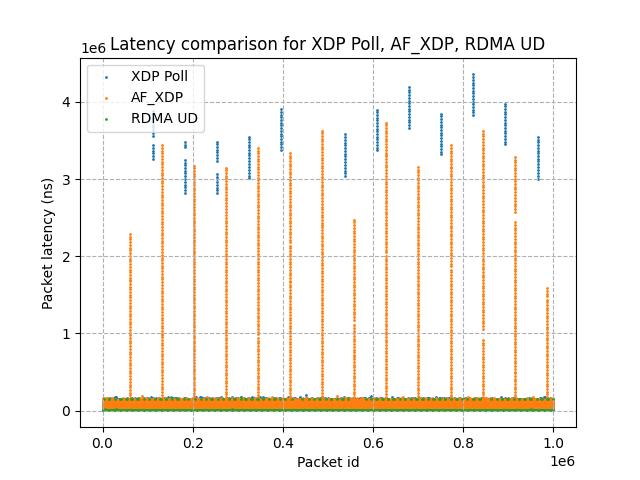

In [60]:
plot_latencies((xdpp_lat, "XDP Poll"), (xsk_lat, "AF_XDP"), (ud_lat, "RDMA UD"), iters=1_000_000)

### Jitter

In [27]:
xdpp_jitter, xsk_jitter, ud_jitter

(43.340931513940895, 68.32760870244513, 9.750415689172444)

### Number of received packets

In [28]:
len(xdpp_lat),len(xsk_lat),len(ud_lat)

(998932, 999864, 996077)

### Average latency

In [34]:
np.mean(xdpp_lat[:,1]),np.mean(xsk_lat[:,1]),np.mean(ud_lat[:,1])

(9704.636977291748, 9863.656197242824, 3599.597128535244)

### Peaks locality in XDP Poll and AF_XDP

In [69]:
peaks = np.diff(np.where(xdpp_diffs[:,1] > 1e6))
np.mean(peaks),peaks

(77533.09090909091,
 array([[ 71040,  71040,  71040,  71104, 142208,  71040,  71040,  71040,
          71040,  71040,  71232]]))

In [68]:
peaks = np.diff(np.where(xsk_diffs[:,4] > 1e6))
np.mean(peaks),peaks

(71166.07692307692,
 array([[71110, 71128, 71192, 71193, 71127, 71192, 71193, 71192, 71127,
         71193, 71192, 71128, 71192]]))

### Average (real) send interval

In [66]:
np.mean(xdpp_diffs[:,1]), np.mean(xsk_diffs[:,1]), np.mean(ud_diffs[:,1])

(70375.71606747613, 70135.78341632803, 9935.89515057084)

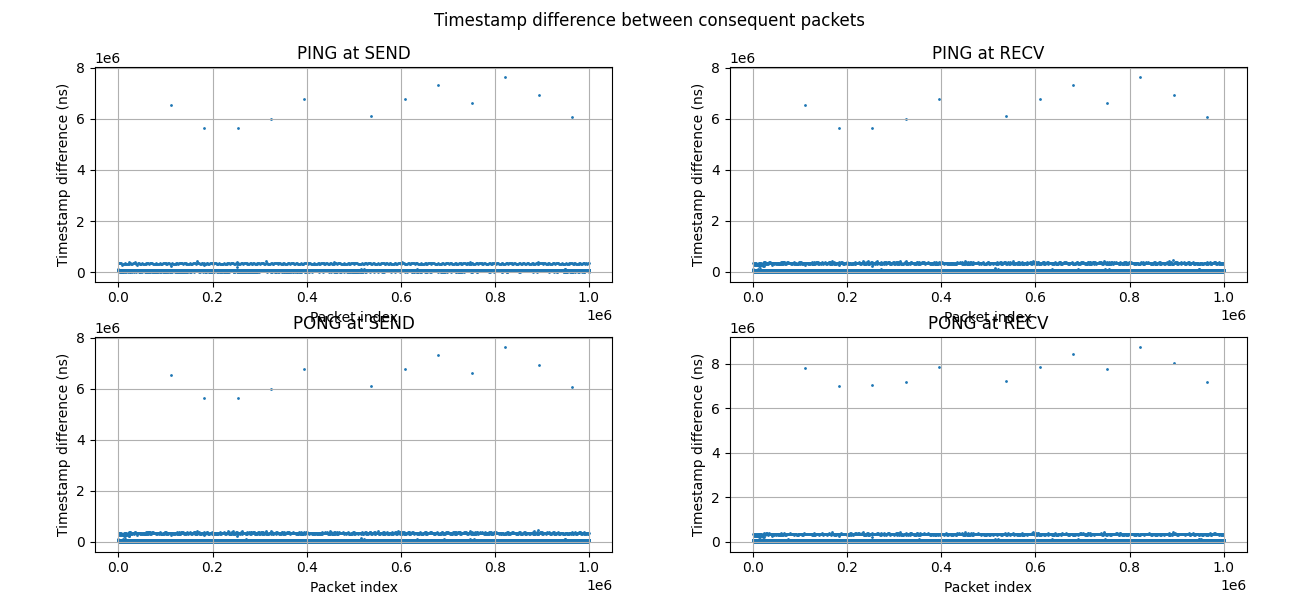

In [61]:
plot_diffs(xdpp_diffs,1_000_000)

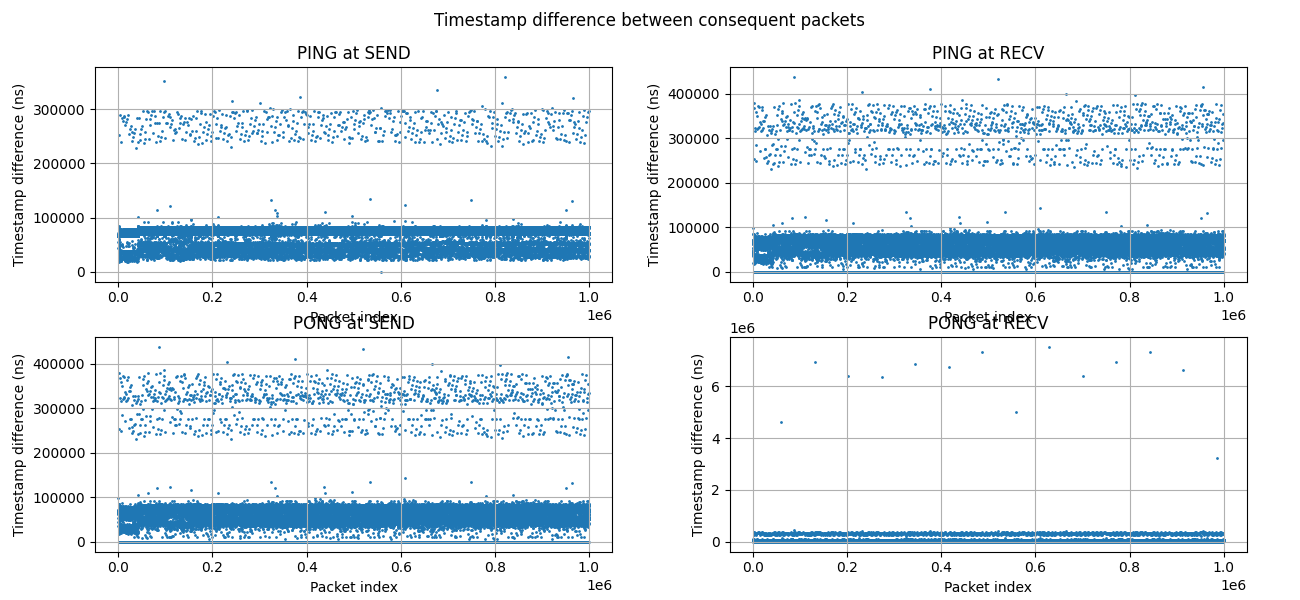

In [62]:
plot_diffs(xsk_diffs,1_000_000)

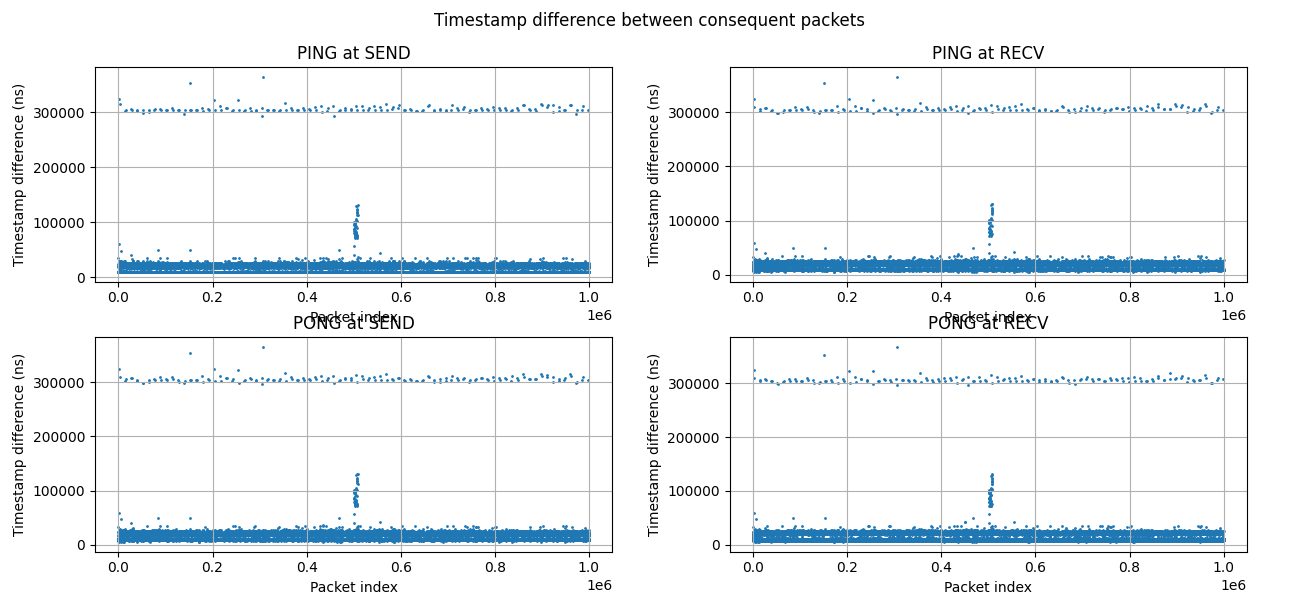

In [63]:
plot_diffs(ud_diffs,1_000_000)

### Considerations

#### 1M packets, 10$\micro$s interval, no isolation
- **RDMA UD**: The communication is stable and latency is low. High packet loss compared to the other methods, and there can be rare cases of data races in packet sending. The better the synchronization the higher the packet loss.
- **AF_XDP**: Can't keep up with a send interval of 10 $\micro$s. Average send interval is around 70 $\micro$. At PONG RECV, there are huge peaks between consecutive packets, every ~71150 packets.
- **XDP Poll**: Similar to AF_XDP; has spikes in PING SEND, probably because of the generic socket used, which goes through the network stack.